# On 'On the Measure of Intelligence' by F. Chollet (2019; ArXiv)
## Author: Robert Tjarko Lange (@RobertTLange)
## Visualizing the ARC Corpus

In [1]:
from os import listdir
from os.path import isfile, join

import json
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='talk', style='white',
        font='sans-serif', font_scale=1, color_codes=True, rc=None)

%config InlineBackend.figure_format = 'retina'

# Data Download & Setup

In [2]:
# Clone the repo with ARC data if required
clone_data_repo = False
if clone_data_repo:
    !git clone https://github.com/fchollet/ARC

In [3]:
# Define the relevant paths after cloning the repo
train_data_path = "ARC/data/training/"
eval_data_path = "ARC/data/evaluation/"

# Get all the filenames
train_tasks = [f for f in listdir(train_data_path) if isfile(join(train_data_path, f))]
eval_tasks = [f for f in listdir(eval_data_path) if isfile(join(eval_data_path, f))]

print("# Training Tasks: {}".format(len(train_tasks)))
print("# Evaluation Tasks: {}".format(len(eval_tasks)))

# Training Tasks: 400
# Evaluation Tasks: 400


In [4]:
def load_task(config_fname):
    """ Load in a task JSON file and return as a dictionary """
    json_config = json.loads(open(config_fname, 'r').read())
    dict_config = DotDic(json_config)

    # Make inner dictionaries indexable like a class
    for key, value in dict_config.items():
        if isinstance(value, dict):
            dict_config[key] = DotDic(value)
    return dict_config


class DotDic(dict):
    """ Helper to load in parameters from json & easily call them """
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __deepcopy__(self, memo=None):
        return DotDic(copy.deepcopy(dict(self), memo=memo))

# Random Task Visualization

In [5]:
def plot_arc_task(task):
    """ Plot an example of a task from the ARC benchmark"""
    num_train_ex = len(task.train)
    fig, axs = plt.subplots(2, num_train_ex+1, figsize=(10, 10))
    for i in range(num_train_ex):
        axs[0, i].imshow(task.train[i]["input"], vmin=0, vmax=10)
        axs[1, i].imshow(task.train[i]["output"], vmin=0, vmax=10)
        axs[0, i].axis("off")
        axs[1, i].axis("off")
        axs[0, i].set_title("Train {}: Input".format(i+1))
        axs[1, i].set_title("Train {}: Output".format(i+1))
        
    
    axs[0, num_train_ex].imshow(task.test[0]["input"], vmin=0, vmax=10)
    axs[1, num_train_ex].imshow(task.test[0]["output"], vmin=0, vmax=10)
    axs[0, num_train_ex].axis("off")
    axs[1, num_train_ex].axis("off")
    axs[0, num_train_ex].set_title("Test: Input".format(i+1))
    axs[1, num_train_ex].set_title("Test: Output".format(i+1))
    fig.tight_layout()

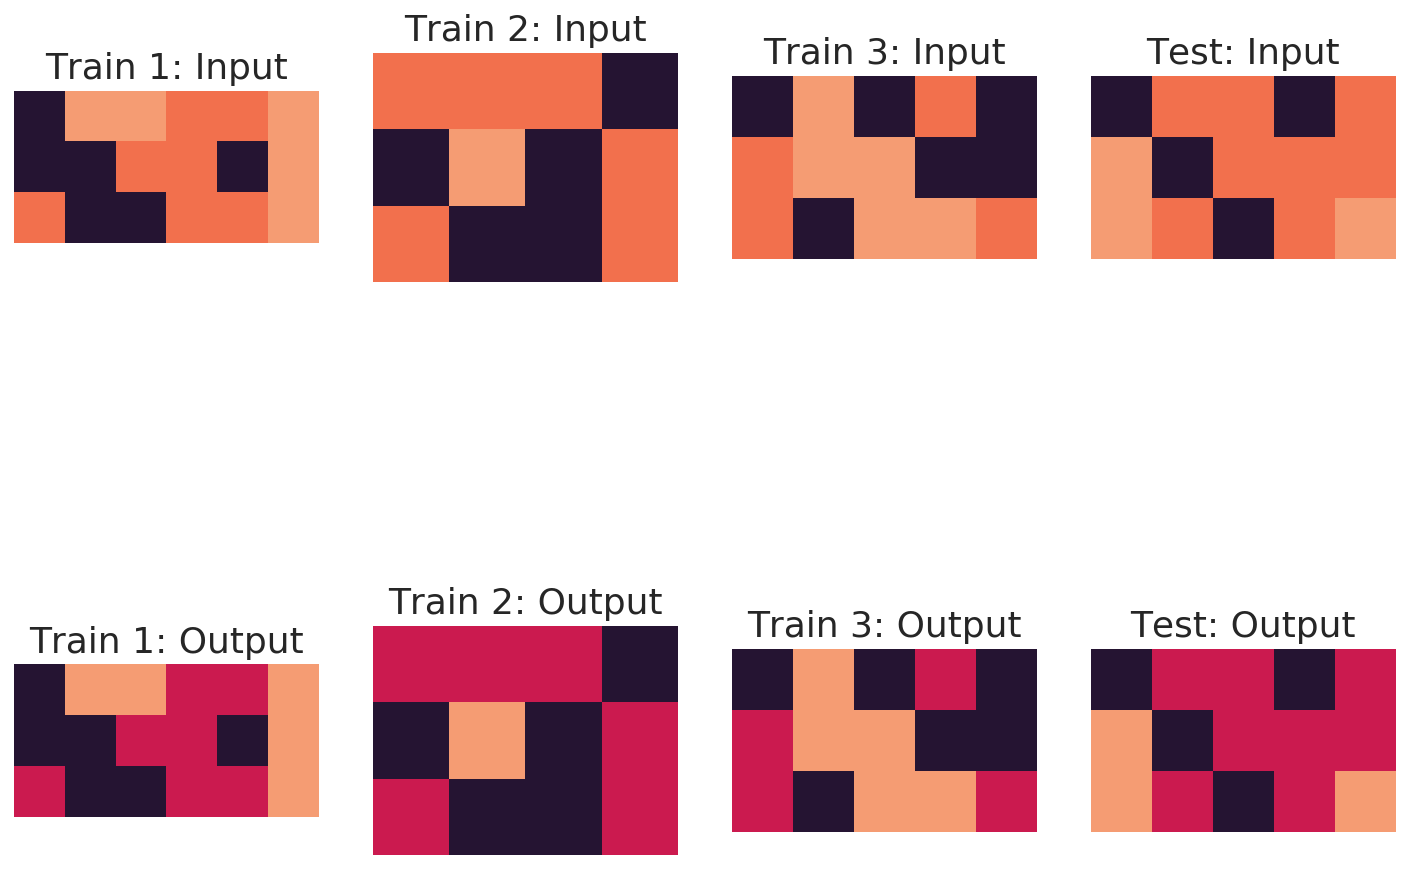

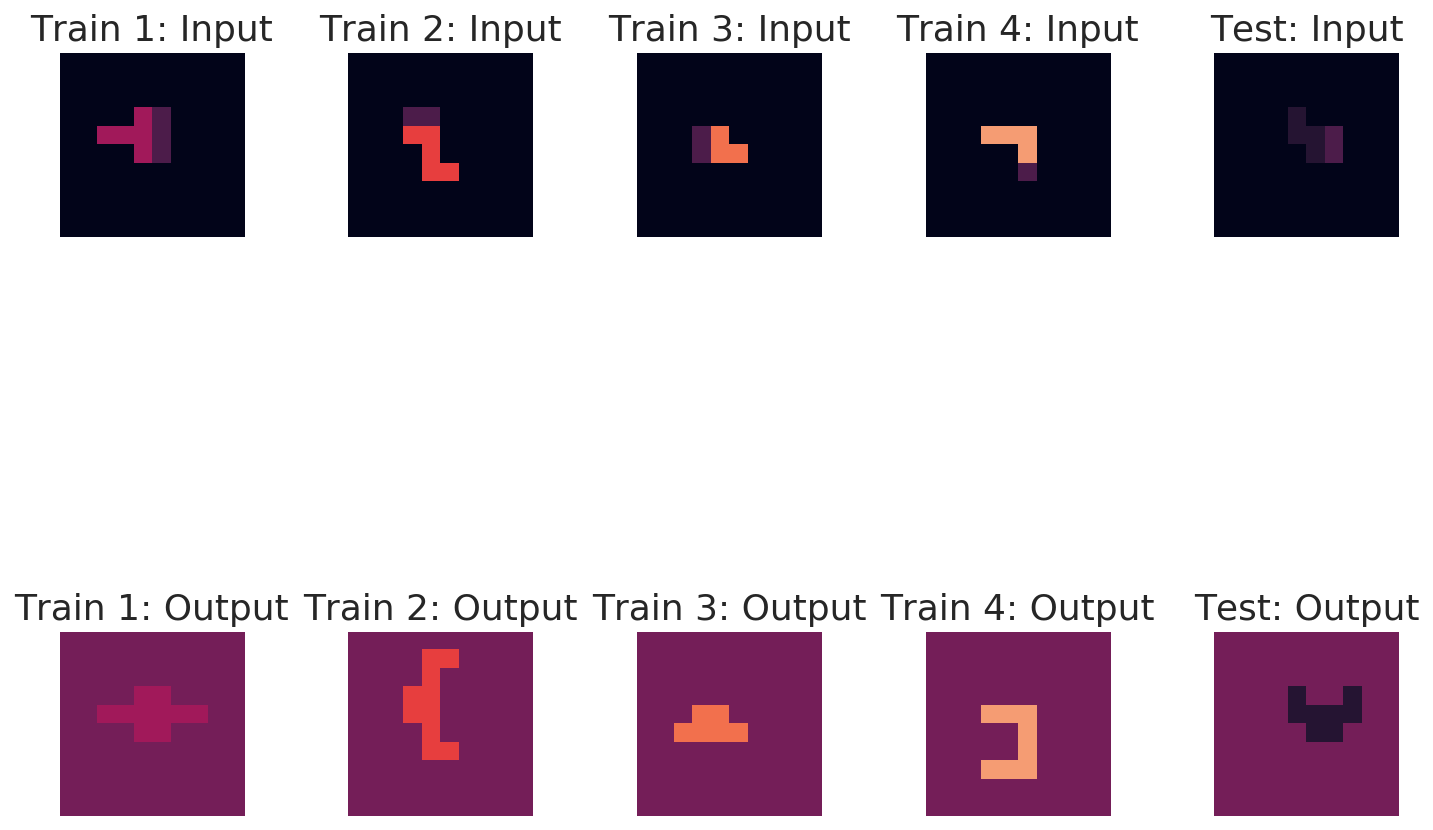

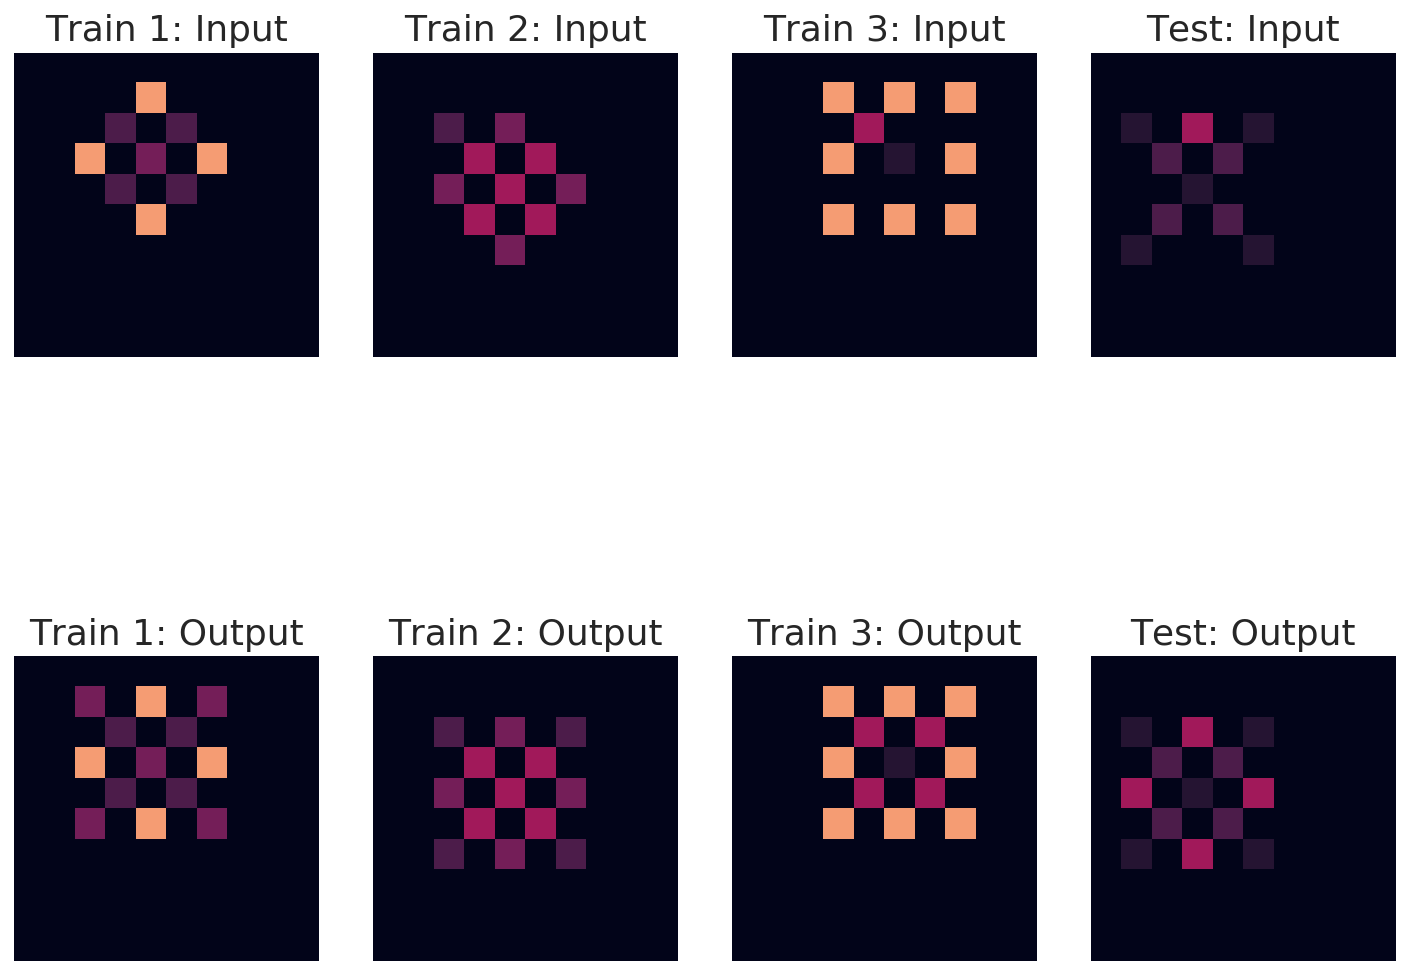

In [6]:
for i in range(3):
    random_task_id = np.random.choice(range(len(train_tasks)))
    example_task = load_task(train_data_path + train_tasks[random_task_id])
    plot_arc_task(example_task)

# Visualize the Distribution of Examples

In [7]:
train_task_examples = []
eval_task_examples = []
for i in range(400):
    train_task = load_task(train_data_path + train_tasks[i])
    train_task_examples.append(len(train_task["train"]))

    eval_task = load_task(eval_data_path + eval_tasks[i])
    eval_task_examples.append(len(eval_task["train"]))

Text(0.5, 0.98, 'Abstraction & Reasoning Corpus - Example Count')

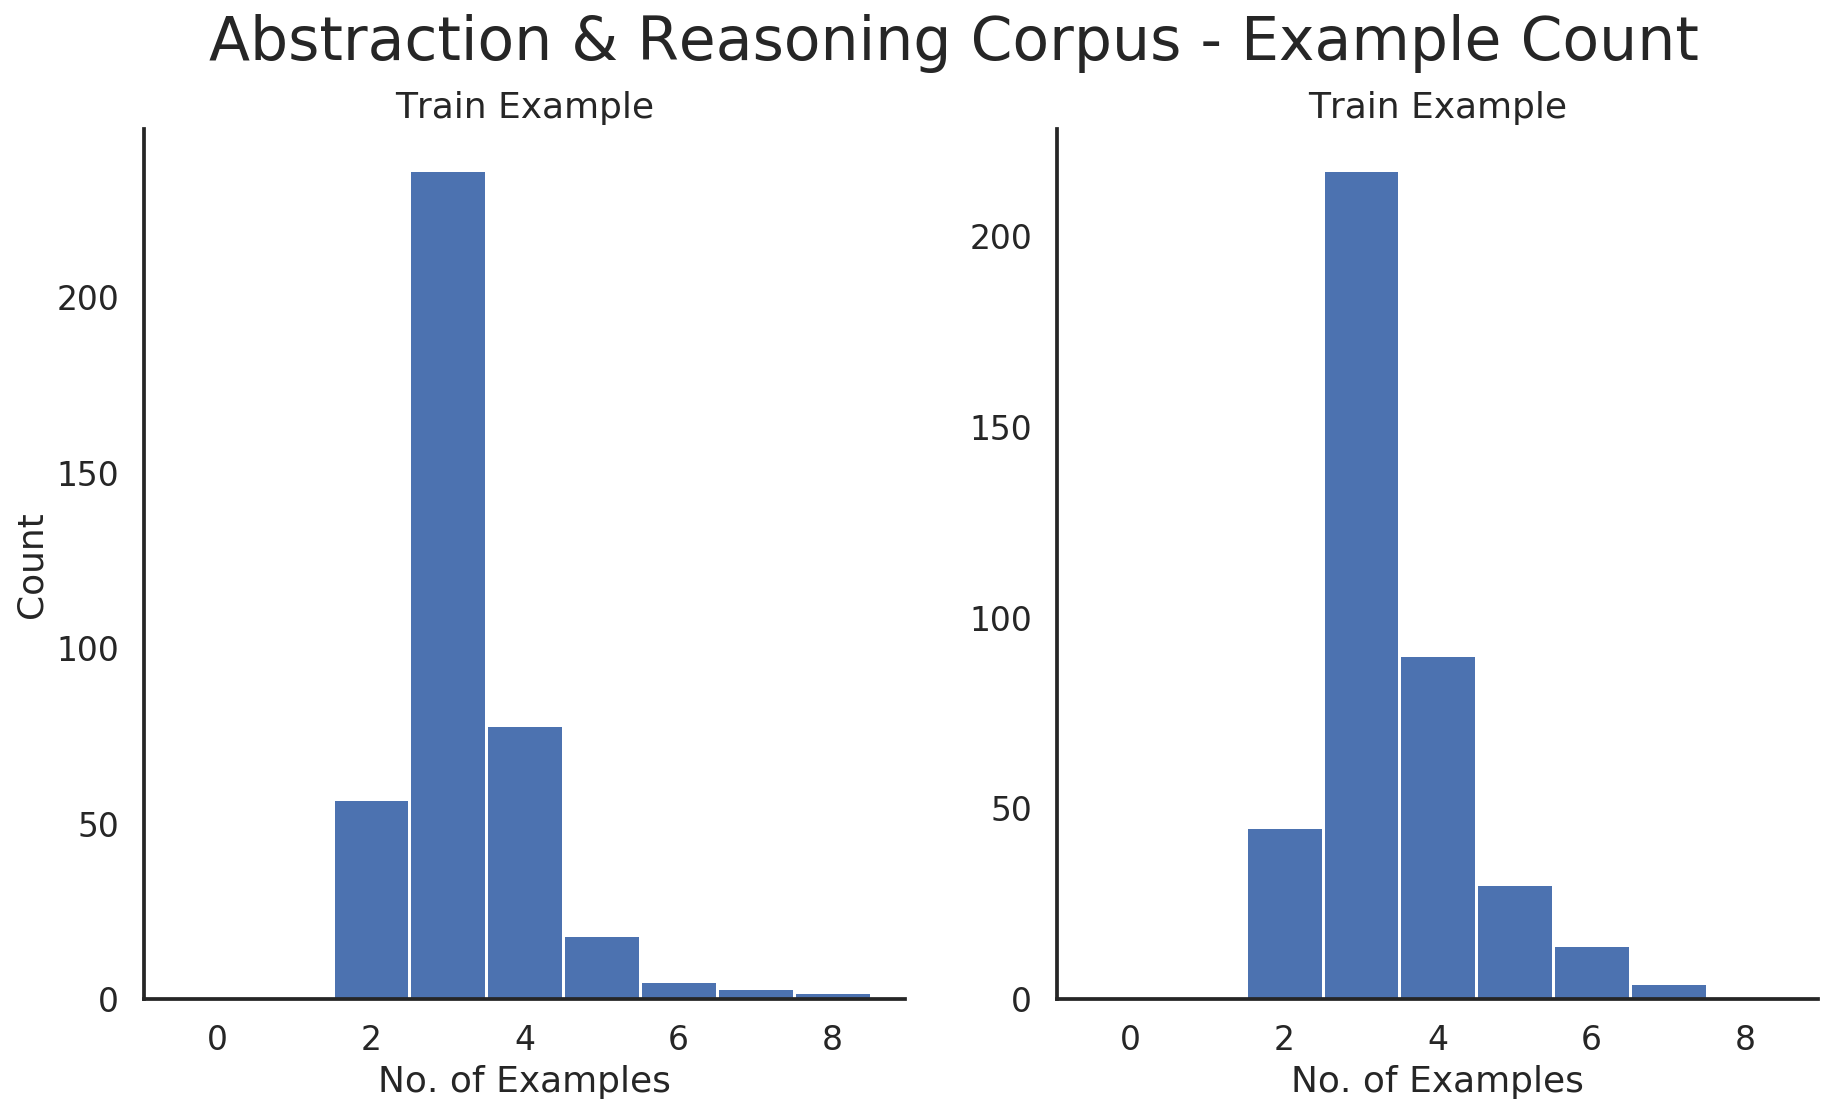

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].hist(train_task_examples, bins=np.arange(10)-0.5)
axs[0].set_title("Train Example")
axs[0].set_xlabel("No. of Examples")
axs[0].set_ylabel("Count")
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

axs[1].hist(eval_task_examples, bins=np.arange(10)-0.5)
axs[1].set_title("Train Example")
axs[1].set_xlabel("No. of Examples")
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

fig.suptitle("Abstraction & Reasoning Corpus - Example Count", fontsize=30, y=0.98)


# Dataset Wrapper for PyTorch Prototyping

In [9]:
import torch
from torch.utils.data import Dataset

import random
from os import listdir
from os.path import isfile, join

In [16]:
class ARC_Dataset(Dataset):
    """ Abstraction & Reasoning Corpus PyTorch dataset wrapper."""

    def __init__(self, train_path, eval_path, batch_size=1, shuffle=False, verbose=True):
        """
        Args:
            train_path: String pointing to directory with training task json files
            eval_path: String pointing to directory with evaluation task json files
        """
        self.train_path = train_path
        self.eval_path = eval_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Get all the filenames
        self.train_tasks = [f for f in listdir(train_path) if isfile(join(train_path, f))]
        self.eval_tasks = [f for f in listdir(eval_path) if isfile(join(eval_path, f))]
        
        self.num_train_tasks, self.num_eval_tasks = len(self.train_tasks), len(self.eval_tasks)
        self.train_task_counter, self.eval_task_counter = 0, 0

        if verbose:
            print("Train Tasks in ARC Corpus: {}".format(self.num_train_tasks))
            print("Evaluation Tasks in ARC Corpus: {}".format(self.num_eval_tasks))

    def __len__(self):
        return self.num_train_tasks

    def __getitem__(self, config_fname):
        """ Load in a task JSON file and return as a dictionary """
        json_config = json.loads(open(config_fname, 'r').read())
        dict_config = DotDic(json_config)

        # Make inner dictionaries indexable like a class
        for key, value in dict_config.items():
            if isinstance(value, dict):
                dict_config[key] = DotDic(value)
        return dict_config

    def sample(self, train=True):
        """ Sample a task & shuffle ordering if epoch is done/looped over all """
        if train==True:
            self.train_task_counter += 1
            # Reset the counter if we have looped over entire set once
            if self.train_task_counter >= self.num_train_tasks:
                self.train_task_counter = 0
            # Shuffle the ordering of the tasks if desired
            if self.shuffle:
                random.shuffle(self.train_tasks)
                
            config_idx = self.train_path + self.train_tasks[self.train_task_counter]
        else:
            self.eval_task_counter += 1
             # Reset the counter if we have looped over entire set once
            if self.eval_task_counter >= self.num_train_tasks:
                self.eval_task_counter = 0
            # Shuffle the ordering of the tasks if desired
            if self.shuffle:
                random.shuffle(self.eval_tasks)

            config_idx = self.eval_path + self.test_data_ids[self.eval_task_counter]

        dict_config = self.__getitem__(config_idx)
        return dict_config

In [18]:
arc_data = ARC_Dataset(train_data_path, eval_data_path)
task = arc_data.sample()

Train Tasks in ARC Corpus: 400
Evaluation Tasks in ARC Corpus: 400
